# Sand Hill Crane Migration 2023

## Sandhill Crane Description 

## Data Description
GBIF and Ecoregions Descriptions with Citations 


## Meathod
Normilzation - why it is necassar, and how did you do it 

## Plot 

## Plot Headline and Description

### Code 



In [1]:
# Dependancies 
import time
import zipfile
import os
import pathlib
import pandas as pd 
from getpass import getpass
from glob import glob
import geopandas as gpd

import pygbif.occurrences as occ
import pygbif.species as species

# Get month names
import calendar
import warnings

# Libraries for Dynamic mapping
import cartopy.crs as ccrs
import panel as pn
import hvplot
import hvplot.pandas
import geoviews as gv

#for getting rid of warnings for portfolio post (don't need to do untill at the end or if warning affecting plots)
warnings.filterwarnings('ignore', category=FutureWarning)

/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


#### Get Ecoregions

In [2]:

# Create data directory in the home folder
species_data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'migration-project-directory-Nolan-Welsh',
)
os.makedirs(species_data_dir, exist_ok=True)
species_data_dir

'/home/jovyan/earth-analytics/data/migration-project-directory-Nolan-Welsh'

In [3]:
# Set up the ecoregion boundary URL
region_url = "https://storage.googleapis.com/teow2016/Ecoregions2017.zip"

# Set up a path to save the data on your machine
region_dir = os.path.join(species_data_dir, 'resolve_ecoregions')
# Make the ecoregions directory
os.makedirs(region_dir, exist_ok=True)
# Join ecoregions shapefile path
region_path = os.path.join(region_dir, 'resolve_ecoregions.shp')

# Only download once
if not os.path.exists(region_path):
    my_gdf = gpd.read_file(region_url)
    my_gdf.to_file(region_path)

<Axes: >

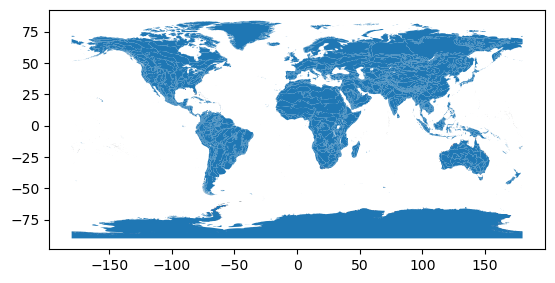

In [4]:
# Open up the ecoregions boundaries
gdf_ecoregions = gpd.read_file(region_path)

# Name the index so it will match the other data later on
gdf_ecoregions.index.name = 'ecoregion'

# Plot the ecoregions to check download
gdf_ecoregions.plot()

#### Download Species Data from GBIF

In [5]:
# Create data directory in the home folder
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'sandhill-crane-migration',
)
os.makedirs(data_dir, exist_ok=True)

# Define the directory name for GBIF data
gbif_dir = os.path.join(data_dir, 'sandhill-crane-migration')

In [6]:
reset_credentials = False
# GBIF needs a username, password, and email
credentials = dict(
    GBIF_USER=(input, 'GBIF username:'),
    GBIF_PWD=(getpass, 'GBIF password'),
    GBIF_EMAIL=(input, 'GBIF email'),
)
for env_variable, (prompt_func, prompt_text) in credentials.items():
    # Delete credential from environment if requested
    if reset_credentials and (env_variable in os.environ):
        os.environ.pop(env_variable)
    # Ask for credential and save to environment
    if not env_variable in os.environ:
        os.environ[env_variable] = prompt_func(prompt_text)

In [7]:
# Query species
species_info = species.name_lookup('Sandhill Crane', rank='SPECIES')

# Get the first result
first_result = species_info['results'][0]

# Get the species key (nubKey)
species_key = first_result['nubKey']

# Check the result
first_result['species'], species_key

('Antigone canadensis', 9036008)

In [8]:
# Only download once
gbif_pattern = os.path.join(gbif_dir, '*.csv')
if not glob(gbif_pattern):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF, used taxonKey instead of species key here, 
        # this worked for me base on what I saw on the GBIF website search
        gbif_query = occ.download([
            f"taxonKey = {species_key}",
            "year = 2023",
            "hasCoordinate = TRUE"
        ])
        download_key=gbif_query[0]
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]
    else:
        download_key = os.environ['GBIF_DOWNLOAD_KEY']
    # Wait for the download to build
    wait = occ.download_meta(download_key)['status']
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(download_key)['status']
        time.sleep(5)

    # Download GBIF data
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path=data_dir)

    # Unzip GBIF data
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=gbif_dir)

# Find the extracted .csv file path (take the first result)
gbif_path = glob(gbif_pattern)[0]

INFO:Your download key is 0014700-241007104925546
INFO:Download file size: 33049709 bytes
INFO:On disk at /home/jovyan/earth-analytics/data/sandhill-crane-migration/0014700-241007104925546.zip


In [ ]:
# Load the GBIF data
gbif_sandcrane_df = pd.read_csv(
    gbif_path, 
    delimiter='\t',
    index_col='gbifID',
    usecols=['gbifID', 'decimalLatitude','decimalLongitude', 'month']
)
gbif_sandcrane_df.head()

,decimalLatitude,decimalLongitude,month
gbifID,,,
4704199879,26.649673,-81.686935,2
4826111054,41.437645,-80.791180,5
4668276308,46.991810,-95.980255,5
4670343687,43.908220,-77.278465,6
4716598123,43.127975,-88.959660,4


In [10]:
gbif_gdf = (
    gpd.GeoDataFrame(
        gbif_sandcrane_df, 
        geometry=gpd.points_from_xy(
            gbif_sandcrane_df.decimalLongitude, 
            gbif_sandcrane_df.decimalLatitude), 
        crs="EPSG:4326") #indicated we are using lat and long, in decimal degrees
    # Select the desired columns
    [['month', 'geometry']]
)
gbif_gdf

,month,geometry
gbifID,,
4704199879,2,POINT (-81.68694 26.64967)
4826111054,5,POINT (-80.79118 41.43764)
4668276308,5,POINT (-95.98026 46.99181)
4670343687,6,POINT (-77.27846 43.90822)
4716598123,4,POINT (-88.95966 43.12798)
...,...,...
4678731776,3,POINT (-85.15653 42.24512)
4816316846,12,POINT (-85.00603 35.40836)
4685501560,1,POINT (-123.5424 46.97668)


#### Normalize Data 

In [11]:
#Use a spatial Join to find all the gbif occurences containing ecoregions

gbif_ecoregion_gdf = (
    gdf_ecoregions
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        predicate='contains')
    # Select the required columns
    [['month', 'gbifID', 'SHAPE_AREA']]
     .reset_index()
     .rename(columns={
         'index':'ecoregion',
         'gbifID' : 'observation_id' #needed to reset index to get unquie IDs for every row 
     })
)
gbif_ecoregion_gdf

,ecoregion,month,observation_id,SHAPE_AREA
0,4,7,4792706312,8.196573
1,4,7,4795806198,8.196573
2,4,7,4620196883,8.196573
3,4,7,4700107974,8.196573
4,4,7,4660852026,8.196573
...,...,...,...,...
304703,833,6,4729374620,35.905513
304704,833,5,4644361401,35.905513
304705,833,5,4763013510,35.905513
304706,833,5,4843448578,35.905513


In [12]:
#count and group mean occurence by ecoregions and by month 
occurrence_df = (
    gbif_ecoregion_gdf
    #reset indes
    .reset_index()
    # For each ecoregion, for each month...
    .groupby(['ecoregion', 'month'])
    # ...count the number of occurrences
    #.agg counts all of GBIF Ids in the group 
    .agg(
        occurrences=('observation_id', 'count'),
        area=('SHAPE_AREA', 'first'))  
)
#normalize by area 
occurrence_df['density'] = (
    occurrence_df.occurrences 
    / occurrence_df.area
)

# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences>1]

# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby(['ecoregion'])
    .mean()
)
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    .groupby(['month'])
    .mean()
)

In [13]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df['density']
    /mean_occurrences_by_ecoregion['density']
    /mean_occurrences_by_month['density']
)
occurrence_df

occurrences       area   density  norm_occurrences
ecoregion month                                                    
4         7                5   8.196573  0.610011          0.085055
9         5                3  28.388010  0.105678          0.013642
          6                2  28.388010  0.070452          0.018565
          8                8  28.388010  0.281809          0.090523
          9               13  28.388010  0.457940          0.112213
...                      ...        ...       ...               ...
833       7              167  35.905513  4.651096          0.087380
          8              173  35.905513  4.818202          0.078276
          9              128  35.905513  3.564912          0.044180
          10              94  35.905513  2.617982          0.029165
          11              25  35.905513  0.696272          0.005931

[780 rows x 4 columns]

<Axes: xlabel='month', ylabel='norm_occurrences'>

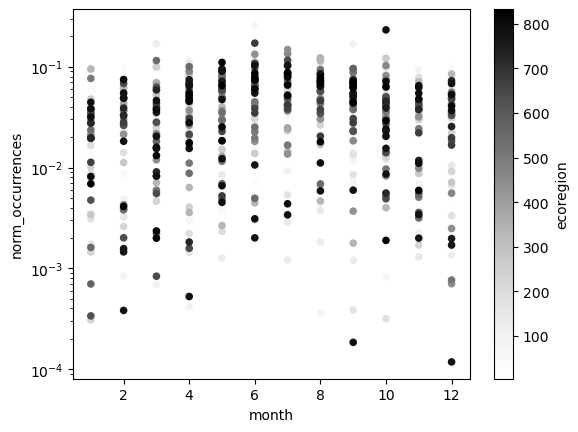

In [14]:
# plot to check distrubions 
occurrence_df.reset_index().plot.scatter(
    x='month', y='norm_occurrences', c='ecoregion',
    logy=True
)

#### Plot 

In [15]:
# Simplify the geometry to speed up processing
gdf_ecoregions.geometry = gdf_ecoregions.simplify(
    1, preserve_topology=False)

# Change the CRS to Mercator for mapping
gdf_ecoregions = gdf_ecoregions.to_crs(ccrs.Mercator())
# Check that the plot runs in a reasonable amount of time
gdf_ecoregions.hvplot(geo=True, crs=(ccrs.Mercator()))

:Polygons   [Longitude,Latitude]

In [17]:
## Make the Plot 

# Join the occurrences with the plotting GeoDataFrame
occurrence_gdf = gdf_ecoregions.join(occurrence_df[['norm_occurrences']])

# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = occurrence_gdf.total_bounds
#set up of month widget slider
month_widget= (
pn.widgets.DiscreteSlider(
            options={
                calendar.month_abbr[month_num] :month_num
                for month_num in range(1,12)
                }
        )

)
# Plot occurrence by ecoregion and month
migration_plot = (
    occurrence_gdf
    .hvplot(
        c='norm_occurrences',
        groupby='month',
        # Use background tiles
        geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
        title="Sandhill Crane Migration, By Month",
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=600,
        #change widget to show months 
        widgets= {'month': month_widget},
        widget_location='bottom'
    )
)

# Save the plot
migration_plot.save('migration_pp.html', embed=True)

# Show the plot
migration_plot

AbbreviatedException: ValueError: failed to validate MultiPolygons(id='p2777', ...).hatch_color: expected an element of either String, Nullable(Color), Instance(Value), Instance(Field), Instance(Expr), Struct(value=Nullable(Color), transform=Instance(Transform)), Struct(field=String, transform=Instance(Transform)) or Struct(expr=Instance(Expression), transform=Instance(Transform)), got dim('norm_occurrences')

To view the original traceback, catch this exception and call print_traceback() method.

: 